In [1]:
# Import the required libraries

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture
from astropy.visualization.stretch import SinhStretch, LinearStretch
from astropy.visualization import ImageNormalize
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from astroquery.astrometry_net import AstrometryNet
from photutils.aperture import SkyCircularAperture
from astropy.time import Time
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
from astropy.visualization import simple_norm
import glob
import os

In [2]:
# User inputs

AstrometryNet_key = 'edqxeasvvonajjpl'

Target_RA = 194.0849
Target_DEC = 21.2909

Ref_RA = 194.1270
Ref_DEC = 21.2909

ap_size = 10 # aperture size, in pixels, 5
an_small = 20 # size of inner ring of annulus, in pixels, 10
an_large = 30 #size of outer ring of annulus, in pixels, 15
imsz = 150 # number of pixels from the middle to the edge of the image, in x and y

plotpath = "/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/" #path where you want to save the lightcurve and csv
fitpath = "/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small" #path where the fits files are

In [4]:
# Plate Solve the FIT file

def AstrometryNet_Plate_Solve(AstrometryNet_key = None, FIT_File = None, Target_RA = None, Target_DEC = None, Ref_RA = None, Ref_DEC = None):

    ast = AstrometryNet()
    ast.api_key = AstrometryNet_key

    try_again = True
    submission_id = None

    while try_again:
        try:
            if not submission_id:
                wcs_header = ast.solve_from_image(FIT_File,
                                                submission_id = submission_id)
            else:
                wcs_header = ast.monitor_submission(submission_id,
                                                    solve_timeout = 3000000000000)
        except TimeoutError as e:
            submission_id = e.args[1]
        else:
            # got a result, so terminate
            try_again = False

        w = WCS(wcs_header)

    Target_Pix = w.wcs_world2pix(Target_RA, Target_DEC, 1)

    Ref_Pix = w.wcs_world2pix(Ref_RA, Ref_DEC, 1)

    # Return the locations of the target star and the reference star in pixels

    return(Target_Pix, Ref_Pix)

In [5]:
def star_counts(pixels, data):
    """ Star Counts

    Using aperture photometry to find the number of counts measured from a star.

    Args:
        pixels (array): numpy vector. Location of the target star in pixels.
        data (array): numpy 2D array. Image data of the star from the fits file.

    Returns:
        float: instrument counts from the star
    """
    #Getting the mean background 
    aperture = CircularAperture(pixels, r=ap_size)
    annulus_aperture = CircularAnnulus(pixels, r_in=an_small, r_out=an_large)
    aperstats = ApertureStats(data, annulus_aperture)
    bkg_mean = aperstats.mean

    #Getting the aperture area
    phot_table = aperture_photometry(data, aperture)
    aperture_area = aperture.area_overlap(data)

    #Getting the photometry within the aperture
    total_bkg = bkg_mean * aperture_area
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    return phot_bkgsub, aperture, annulus_aperture #total counts within the aperture, aperture object, annulus_object

/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0001.fit


Determining background stats


Finding sources
Found 371 sources
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
205  926.9693863203142 ...  72.35757305141611   -4.6487099793537014
315  983.4766722198685 ...  71.68134108899761    -4.638515304906065
 30 1170.9128545350977 ...   64.6553691352988    -4.526511488896085
109 1565.2716993354243 ...  64.60795096319963    -4.525714919096058
296  682.6837851681375 ...  63.56500409234416    -4.508045198216355
 55 2692.5085304336303 ... 63.415693500303604    -4.505491865413507
214 1765.2405222029454 ...  62.63677839251428   -4.4920735312161115
363 2106.1283927005093 ...  61.94765478682276    -4.480062173776939
116  2463.581774227599 ...  61.92651139377827    -4.479691537214844
234  1051.831698613733 ... 59.718879623618946    -4.440279128499675
...                ... ...                ...                   ...
 95 1900.9053911768306 ...  1.034019249460984  -0.03632155931470654
 38  2473.3269



/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0002.fit


Determining background stats
Finding sources
Found 371 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
205  927.1917818484384 ...  71.35459405341776     -4.633554849296584
314  983.5943152969111 ...     68.85181884626     -4.594788543561533
117 2463.8006459152484 ...  66.98105321830951     -4.564879930393312
294  682.9203666592515 ...  66.55078456729636     -4.557882949347886
 58 2692.6945537138777 ...  64.55928028706421     -4.524896700463055
110   1565.54756935854 ...  63.69898885909607     -4.510331346285773
233 1052.0129863151574 ... 61.874675401406236    -4.4787823340258655
141 1566.6838205687732 ...   61.4616380438576    -4.4715103266675005
213 1765.5485853311834 ...  58.48722531782807    -4.4176525464096885
 22 1419.9236696797986 ... 57.444099427296436



/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0003.fit


Determining background stats


Finding sources
Found 371 sources
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
313  986.8281561741456 ...  76.79024273905276    -4.713265101062032
292  686.0256607699165 ...  72.95039230984258    -4.657569079420204
201  930.4205072960341 ...  72.65260621612944      -4.6531279951392
109 2467.0606802089505 ...   69.5957052292347    -4.606456100003629
 51 2695.8957854789955 ...   68.0983363897753    -4.582841256082783
231 1055.2046288449271 ...  65.61296514103638   -4.5424741614292286
210 1768.6583051364514 ... 63.595351407590265    -4.508563428593676
137 1569.8491129781203 ... 62.355944107998084    -4.487194647754467
102 1568.6395834673003 ... 60.862272024302655    -4.460870401981086
274 1124.2728239518772 ...  58.91383912178288    -4.425543311171988
...                ... ...                ...                   ...
189  429.5665759409682 ... 1.0686715165130756  -0.07211058554673788
331 1648.94954

Finding sources
Found 353 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
195  930.3129045621945 ...  71.86941498948656     -4.641360274383699
298  986.8093067078084 ...  71.73536989372164     -4.639333355072769
280  685.9621353200341 ...  70.86035669152695    -4.6260083353037915
109  2466.931392474798 ...  65.37633986380798     -4.538551506676678
223 1055.1369009048062 ...   65.2883299416185      -4.53708889901859
 52  2695.806660204838 ...  63.88986778913206     -4.513579973558171
204 1768.5671039809092 ... 62.745218450345725     -4.493951589137578
132 1569.7711638373776 ...  62.46639694700238     -4.489116141559375
264 1124.1880513610447 ...  56.86378038466695     -4.387089322066348
102 1568.5328113634723 ...  53.68280295456152     -4.324587959217482
...                ... ...                ...                    ...
330  634.3337881694382 ... 1.0472419102312978   -0.05011753548484429


Finding sources
Found 371 sources
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
315  990.9221359563746 ...  75.76207924167767    -4.698629712730779
116 2471.1355209911667 ...  71.78287328803972    -4.640052095154868
295  690.0715189055237 ...   71.7535031135612    -4.639607772077807
205  934.5761412106817 ...   71.5131646144022    -4.635964992373962
213 1772.8184598297944 ...  68.56192824697501    -4.590207558141301
 56 2700.0422149812225 ...  68.02090874412382    -4.581606074281456
235  1059.341034524239 ...  67.04559258372755    -4.565925584123783
143 1573.9848564312304 ...  66.23935703528882    -4.552790270591616
109  1572.754731417709 ...  64.01336792997674    -4.515676693240448
 20 1427.2201662500795 ...  59.49145627703184    -4.436136500112806
...                ... ...                ...                   ...
129  2165.295077890353 ... 1.0508272099537512  -0.05382827453082349
 27 1617.51970



/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0006.fit


Determining background stats


Finding sources
Found 364 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
204   937.235745845818 ...  73.61898994997067     -4.667474636615136
113 2473.8644734623854 ...  70.24910152841382     -4.616601935188441
 56 2702.7133436479508 ...  67.24669666293259     -4.569177388738312
231 1062.0809379966738 ...  66.78954647280142    -4.5617712361124845
309  993.6779206862806 ...  65.69860519680715     -4.543890373604165
291  692.9024900677723 ...  64.62769772253074     -4.526046712558888
212 1775.5711595672988 ...  63.43566050248129     -4.505833665428403
138 1576.6910409209831 ...  62.51114192428882     -4.489893581159089
106 1575.5437546483515 ... 62.313048774543766     -4.486447500973097
 20  1429.992870816401 ...  54.33157448947327     -4.337630726884967
...                ... ...                ...                    ...
195 1361.8991506610034 ... 1.0437206899791809   -0.04646073174642404


Finding sources
Found 344 sources
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
249 343.79296230430504 ...  99.46556406931897    -4.994181874647849
186  940.9841858749547 ...  74.84859580506907    -4.685459142965868
194 1779.2927446782855 ...  70.73672754077798    -4.624112410966543
213   1065.87026017709 ...  66.24953468494903   -4.5529570806931075
288  997.5126097460412 ...  64.77295526624206    -4.528484280481814
100 2477.5913485465635 ...  64.50205034486689     -4.52393379973968
271   696.628779927885 ...  64.46056833552474    -4.523235325694984
 93 1579.2817015875835 ...    64.050842903253    -4.516312123485245
124 1580.5181273569426 ...  62.13774029406912   -4.4833886390474404
 46  2706.525428315461 ...  61.77608874637902   -4.4770510204494744
...                ... ...                ...                   ...
244  1284.447216502735 ... 1.0514472322855142   -0.0544687053892751
142  2561.7274



/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0008.fit


Determining background stats


Finding sources
Found 389 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
217  940.9490998774554 ...  79.40789170061278      -4.74965916386738
120 1579.2049919018411 ...  74.42535634127346     -4.679302306707328
226 1779.2641325527686 ...  73.23508621895616      -4.66179799296603
127  2477.557746790447 ...  72.04236907240362      -4.64396996477445
332  997.5646211364214 ...    71.031126484508     -4.628621755535777
199  2383.175689708404 ...  68.31288960338573     -4.586256640443706
152 1580.3642880736759 ...  68.29663852395151     -4.585998321926202
312  696.6528449133143 ...  67.44093741236378     -4.572308995611535
 22 1433.6915208285568 ...   66.9519035201775     -4.564407322546967
248 1065.8377926322223 ...  66.25791060316796     -4.553094341473447
...                ... ...                ...                    ...
145 2593.2365285141022 ... 1.0715469786876348   -0.07502804025879502




/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0009.fit


Determining background stats


Finding sources
Found 363 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
202  935.9541064116426 ...    73.156098596901    -4.6606263414157905
211 1774.2389839878615 ...  71.44948052838122     -4.634997689028891
112  2472.563092029118 ...  70.29598746305426     -4.617326339847284
105 1574.2189753733246 ...  69.57300829343511      -4.60610195596465
 53 2701.3792812576844 ...  68.62565439399746     -4.591216246954918
290  691.6603498658737 ...   65.0029755182015     -4.532333092436323
230  1060.837401796256 ...    64.921426665927     -4.530970137494686
308  992.4740262678444 ...  64.07781497804578     -4.516769235251447
137 1575.4293811578702 ...   61.5617701616015     -4.473277747861354
185  2378.165918556849 ...  60.02929265075047     -4.445908064799573
...                ... ...                ...                    ...
197 1637.7062515573882 ... 1.0405265886731256   -0.04313295564226077




/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0010.fit


Determining background stats


Finding sources
Found 362 sources
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
200  934.4149803744954 ...   73.3709360145979      -4.6638101488312
288  690.0605406014442 ...  71.55298497823551    -4.636569389877356
113 2470.9398525342776 ...  70.46182519260017    -4.619884721609518
306  990.8966063598772 ...  70.16708859660909    -4.615333642417287
208 1772.6693792411347 ...  67.27664230103824    -4.569660770495758
227 1059.2191812071105 ...  66.55508985001741    -4.557953185185996
139  1573.836703151771 ...   66.4473308709461    -4.556193851033557
106 1572.5810677448885 ...  66.34830600214829    -4.554574597454372
 53 2699.7851059386685 ...   65.2341463753264    -4.536187459440279
 19 1427.0231128478656 ... 62.162925026826386     -4.48382860413476
...                ... ...                ...                   ...
257 1451.1873458975715 ...  1.038298107095329  -0.04080515564797159
182  385.65022



/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0011.fit


Determining background stats


Finding sources
Found 361 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
108 1568.7955768563047 ...  71.11583401981297     -4.629915769118013
142 1569.9895998278469 ...  69.91083360404384     -4.611361201520415
204  930.4551907510846 ...  69.32161340026681     -4.602171654964729
 55 2696.0209652551807 ...  68.93698567025534     -4.596130723956467
212 1768.8497603676492 ...  67.63224581720308     -4.575384522453075
292  686.2646722919849 ...  67.62639834212993     -4.575290645785351
115 2467.1574644092652 ...  67.60518988602792     -4.574950092381705
309  987.0592693216462 ...   64.4343181775511     -4.522793093298375
 19 1423.3015806628223 ... 62.799288780666366     -4.494886813149476
188  2372.829853941976 ... 60.703379769028146     -4.458032179672356
...                ... ...                ...                    ...
 50  264.8085596168111 ...  1.041432803179557  -0.044078132541384804


Finding sources
Found 360 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
204   930.256558333077 ...  72.70379301469222     -4.653892672346348
289  685.8999562538854 ...  68.12706585876046    -4.5832992121551195
114 2466.8268364821215 ...  66.52492145372936     -4.557460926125757
213 1768.5900068801025 ...  65.56876142461816     -4.541742450109777
307  986.7650184121896 ...  65.29244015689086     -4.537157249198002
231 1055.0891053156247 ...  64.65162953300846     -4.526448689176952
107 1568.5170605505314 ...  62.87875152356309     -4.496259775174986
141  1569.664366735572 ...  60.60591234021658     -4.456287483331671
 50  2695.648561093854 ... 59.965125584376935     -4.444746868890958
 17 1422.9702250449452 ... 58.411810432028176     -4.416251667733064
...                ... ...                ...                    ...
128 2161.0773340063206 ... 1.0636223053592895   -0.06696859100027368




/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0014.fit


Determining background stats


Finding sources
Found 384 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
217  922.8697520674484 ...  78.02110735528471     -4.730530274926512
119  1561.237651065085 ...  72.16816146739777    -4.6458641037344375
226 1761.1886372387148 ...  68.74399643485438     -4.593086940653478
325  979.4462528561212 ...  68.40335176504666     -4.587693456690653
151 1562.3734153976611 ...  67.43731035710405     -4.572250601833765
199 2365.0926428089074 ...  66.57828015890746     -4.558331430823651
126 2459.6207838762098 ...  65.36812660196316     -4.538415096532573
 60 2688.4013122517986 ...    64.618281272616     -4.525888506002826
306   678.595302187096 ...  64.51671198442872     -4.524180564980248
246 1047.8051020624632 ...  63.49623931583989     -4.506870010366004
...                ... ...                ...                    ...
 70 1579.2475507189577 ... 1.0541194573427757   -0.05722457445191266




/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0015.fit


Determining background stats


Finding sources
Found 322 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
 85 1562.1298548423454 ...   54.0148617609581     -4.331283172370299
175  923.8432626408536 ...  53.72379303822003      -4.32541666847157
270  980.3379199822488 ...  52.65154292726882     -4.303527756229237
 92 2460.5061675147585 ...  52.25404395255038     -4.295299765585338
 42 2689.3560958436383 ...  51.24368056854919    -4.2741007882985995
117 1563.3464117327962 ...  51.10417135291113      -4.27114087663884
184 1762.1553195945812 ...  48.34004240023669     -4.210767567505348
254  679.5727362426519 ...  48.06582425512219     -4.204590985489574
314   2102.96626374698 ... 44.647943333214634     -4.124503645765339
202 1048.8206587276497 ...  44.17361169954173      -4.11290727316615
...                ... ...                ...                    ...
205  1701.751534826375 ... 1.0478039898948568   -0.05070011962325373




/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0016.fit


Determining background stats


Finding sources
Found 171 sources
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
 97  925.0145815421213 ... 17.568558193604012   -3.1118403038157743
135  680.8084232539528 ... 16.431310150145055    -3.039180483191066
 46 1563.2203827128344 ... 16.297630625493525   -3.0303111764900548
 24 2690.3985709050544 ...  15.98005828015806   -3.0089458971922554
 49  2461.475216632012 ... 15.600085657603485    -2.982817457508333
104 1763.3661347881546 ... 15.570904431539493   -2.9807845979294694
 64 1564.5305356356575 ... 15.541543662809987   -2.9787353821959046
112 1049.9109804218617 ... 15.437405216131621   -2.9714357602360923
146  981.5631748870597 ... 14.395825797334258    -2.895591456630044
 90 2367.2064397220493 ...  13.57332702493932    -2.831715781911596
...                ... ...                ...                   ...
129 1885.8260491633735 ...   1.12644255088664   -0.1292726184915273
 32  2267.5746

Finding sources
Found 128 sources
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
 71  926.3434791496085 ... 10.986608458718797   -2.6021591184597934
107  982.7573264109099 ... 10.805889916276806    -2.584151347255339
 36 2462.8487070791616 ... 10.764253221407394   -2.5799597642023517
 85  1051.102428178648 ...  10.22391756403995    -2.524043347725637
102  681.9200302323998 ... 10.020709211626771    -2.502246149086607
 19 2691.7011389754653 ...  9.452630130482506   -2.4388816620743907
 34 1564.5736728578333 ...  9.373281680091065    -2.429729170932001
 46 1565.7681823827174 ...  9.306832456534027    -2.422004739316986
 75 1764.6366100159212 ...   9.27734546830115   -2.4185593227169595
122  2105.501133821829 ...  8.163375167571555   -2.2796743900180174
...                ... ...                ...                   ...
 61 2062.6751394663797 ... 1.1315768489234577   -0.1342101339727141
 29  2618.3618



/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0018.fit


Determining background stats


Finding sources
Found 120 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
 66  925.0058643644383 ... 10.477392715602777    -2.5506330563081896
 32  2461.748865554563 ...  9.809903577289191    -2.4791618466718295
 71 1763.4675378579802 ...  9.516633298411064     -2.446208337735716
 93  680.7508583441995 ...  9.355021263476646    -2.4276119474147855
 79 1049.9320245054619 ...  9.287065331410583    -2.4196962516894307
 30 1563.3413646829172 ...  9.066770985872548     -2.393631615472417
 17  2690.588740050837 ...  8.648156846579765    -2.3423088939063783
 40  1564.604304183715 ...  8.630514460955744     -2.340091711447611
 99  981.5795346370361 ...  8.502145852404084     -2.323821377298457
  5   1417.80761636017 ...  8.123976831977908     -2.274421690525147
...                ... ...                ...                    ...
 78  455.4108706853742 ...  1.107359154266681   -0.11072125052298813




/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0019.fit


Determining background stats


Finding sources
Found 150 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
 86  925.8459819806425 ... 12.863646120254081     -2.773410210247788
 92 1764.1043679011543 ... 12.268428264308511    -2.7219723196413876
 58  1565.203232120948 ... 12.009276003806898    -2.6987920653371473
 44 1564.0197318502517 ... 11.903572819054327    -2.6891933326230526
 46  2462.431425526475 ... 11.340556975344162     -2.636585962092915
 23 2691.2676566120845 ... 11.304503258342187     -2.633128708410502
120  681.5888263769042 ...  11.27222218580903     -2.630023851317795
129  982.4308093373833 ... 11.194189392217986    -2.6224816259326245
102 1050.7966750805545 ... 11.171099733311786     -2.620239822806739
 80   2368.01513304888 ... 10.951922787064666    -2.5987259332152277
...                ... ...                ...                    ...
128  359.7529047397054 ... 1.0990858986084655   -0.10257908964342129




/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0020.fit


Determining background stats


Finding sources
Found 98 sources
 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
 64 1053.9717627830255 ...  9.376805189240011   -2.430137233200992
 74  684.8156837780892 ...  9.258083687384193  -2.4163027555490633
 57 1767.3870333628677 ...  9.121889862386357   -2.400212060672566
 34  1568.531435915909 ...  8.719553767663038  -2.3512356500606706
 53  929.0557374928649 ...  8.195801771313327   -2.283978614358924
 15  650.8680739272489 ...  7.796904907989603    -2.22980559386026
 70 1122.8675332073597 ...  7.667327129570246    -2.21160998249706
 28  2465.587282791385 ... 7.5531420485919485  -2.1953191308940987
 14  2694.457198382639 ...   7.47201754545989   -2.183594707535642
 78  985.6059482112344 ... 7.1380009564469855   -2.133941504530899
...                ... ...                ...                  ...
 86 2044.8561738443686 ... 1.2453087916112353 -0.23819263533573182
 22 1226.7530111809165 ... 1.



/Users/emilywhittaker/AnacondaProjects/CodeAstro/group_project/codeastro_project/Small/ZTFJ1256+2117_07_21_2021_L_60sec_0021.fit


Determining background stats


Finding sources
Found 86 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
 39 1929.0556574523691 ... 10.541818823189496     -2.557288869868757
 34  2811.231265715056 ...  10.50339926503866    -2.5533246865165005
 32  916.4295258926738 ... 10.163154070978841     -2.517571273571995
 65 1120.5833437020497 ... 10.067817370633223     -2.507338322205314
 40  1929.165542584027 ...  9.949467356969906     -2.494499578718427
 62 2969.5999761103644 ...   9.68726786133862     -2.465503271302662
 27 335.60774968268294 ...  9.607764899059445    -2.4565559184677683
 28 335.98119108834186 ...  9.525397674322486    -2.4472077900446347
  2  2196.706961177632 ...   9.36449995759801     -2.428711480051267
 14   648.633941500944 ...  9.359812991166006     -2.428167929079232
...                ... ...                ...                    ...
 57 3012.1328554583897 ... 1.1658489581550828   -0.16660572235080978
 

KeyboardInterrupt: 

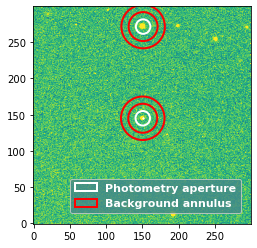

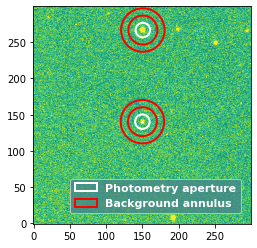

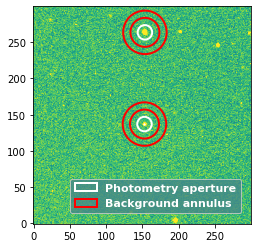

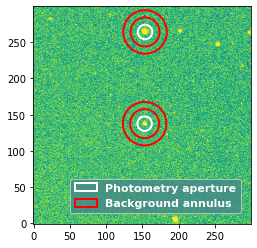

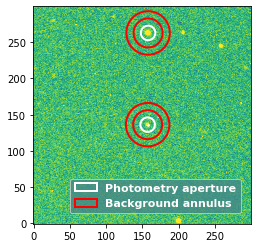

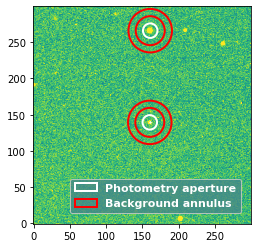

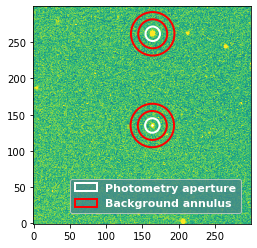

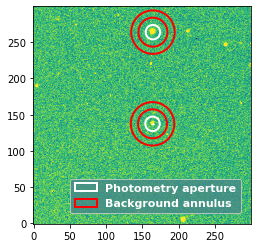

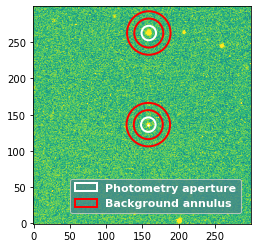

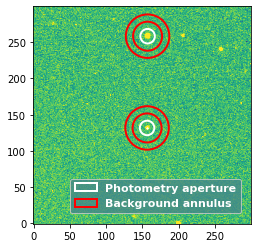

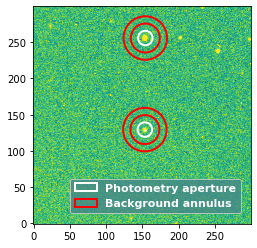

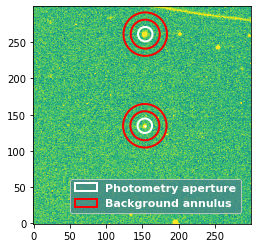

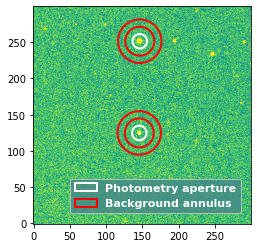

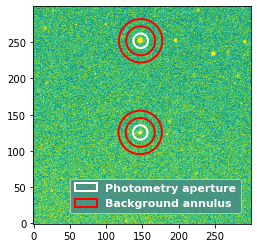

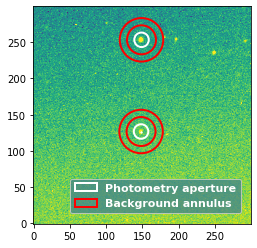

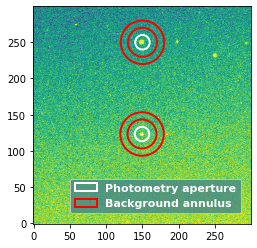

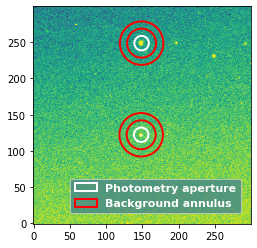

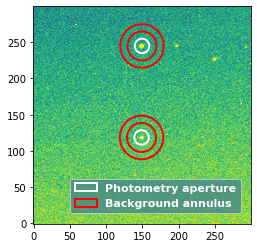

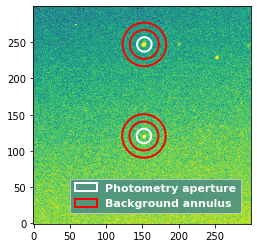

In [22]:
files = sorted(glob.glob(fitpath+'*.fit'))

#path = 'Small/' 
#files = os.listdir(path)

#files_txt = [i for i in files if i.endswith('.fit')]

relstars_lst = []
mjds_lst = []

#for i in range(len(files_txt)):
#for i in range(10,11):

for i in range(len(files)):

    #fitsfile = None

    #fitsfile = files_txt[i]

    #importing the fits file and extracting data

    print(files[i])
    
    print("\n")
    
    FIT_File = get_pkg_data_filename(files[i])
    
    (Target_Pix, Ref_Pix) = AstrometryNet_Plate_Solve(AstrometryNet_key, FIT_File, Target_RA, Target_DEC, Ref_RA, Ref_DEC)

    image_data = fits.getdata(FIT_File, header=True)
    data = image_data[0]
    hdr = image_data[1]

    #Extracting the time from the image header and converting to MJD
    time = hdr['DATE-OBS']
    #print(time)
    t = Time(time, format='isot', scale='utc')

    mjds_lst.append(t.mjd)

    #Getting more precise pixel location by measuring brightness
    """
    #boxsz = 20 #size of the test box, in pixels
    #small_data = data[limx-boxsz:limx+boxsz, limy-imsz:limy+boxsz]
    """
    #Shrinking the data to a reasonable size
    limx = data.shape[0]//2
    limy = data.shape[1]//2
    small_data = data[limx-imsz:limx+imsz, limy-imsz:limy+imsz]
    small_pixels = [Target_Pix[0]-limy+imsz, Target_Pix[1]-limx+imsz]
    small_refpixels = [Ref_Pix[0]-limy+imsz, Ref_Pix[1]-limx+imsz]
    
    #Checking that the location in pixels is correct by plotting
    norm = simple_norm(small_data, 'sqrt', percent=99)
    plt.figure()
    plt.imshow(small_data, norm=norm)
    plt.scatter(small_pixels[0], small_pixels[1], color='w', marker='*', s=2)
    plt.gca().invert_yaxis()

    #Getting the instrument counts for the star and the reference star
    star_cts, star_aperture, star_annulus = star_counts(small_pixels, small_data)
    refstar_cts, refstar_aperture, refstar_annulus = star_counts(small_refpixels, small_data)

    #Relative counts (star - reference star)
    rel_star_cts = star_cts - refstar_cts
    relstars_lst.append(rel_star_cts[0])

    #Plotting the annulus and aperture as a check
    ap_patches = star_aperture.plot(color='white', lw=2,
                            label='Photometry aperture')
    ann_patches = star_annulus.plot(color='red', lw=2,
                                        label='Background annulus')
    handles = (ap_patches[0], ann_patches[0])
    plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
            handles=handles, prop={'weight': 'bold', 'size': 11})

    ref_ap_patches = refstar_aperture.plot(color='white', lw=2,
                            label='Photometry aperture')
    ref_ann_patches = refstar_annulus.plot(color='red', lw=2,
                                        label='Background annulus')
    
    print("\n")

#plt.savefig(fname = "Test", dpi = 200)

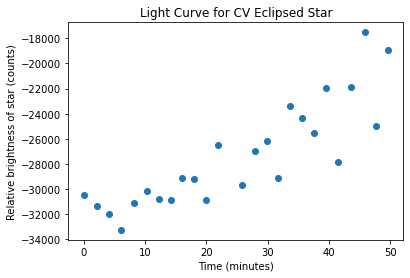

In [21]:
#Plotting the light curve
relstars = np.array(relstars_lst)
mjds = np.array(mjds_lst)
# Setting the first observation to t = 0 and plotting time in minutes instead of days
time_mins = (mjds - min(mjds)) * 24 * 60

plt.figure()
plt.plot(time_mins, relstars)
plt.xlabel("Time (minutes)")
plt.ylabel("Relative brightness of star (counts)")
plt.title("Light Curve for CV Eclipsed Star")
plt.savefig(plotpath+"light_curve.png", dpi=200)